In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding

In [2]:
# imports
import os
import pandas as pd
import numpy as np

import random

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()

import nltk
#file for punkt splitter
nltk.download('punkt');
#file for vader sentiment
nltk.download('vader_lexicon');

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=20,20
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\emiel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\emiel\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<br><br>

## Data loading/collection

In [3]:
series_len = 100
mask_value = -10
max_len = 0

def text_to_sentiments(text):
    sentences = nltk.tokenize.sent_tokenize(text)
    scores = [ sia.polarity_scores(s)['compound'] for s in sentences] #list of compound score per sentence
    
    if len(scores) < series_len:
        t  = series_len - len(scores)
        scores = np.pad(scores, (t, 0), mode='constant', constant_values=mask_value)
        scores = scores.reshape((series_len, 1))
    else:
        scores = np.array(scores[(-1*series_len):])
        scores = scores.reshape((series_len, 1))
        
    return scores

In [4]:
%%time

df = None
try:
    with open(os.path.join('out', 'truefake_series.pickle'), 'rb') as f: df = pickle.load(f)
    print('Succesfully loaded data')
    
except FileNotFoundError:
    print('ERROR: Couldn\'t find data, will start building it now...')
    dataset_path_true = os.path.join("sources", "ISOT", "True.csv")
    dataset_path_fake = os.path.join("sources", "ISOT", "Fake.csv")

    dataset_load_true = pd.read_csv(dataset_path_true, encoding='utf-8') # make sure to use the right encoding
    dataset_load_fake = pd.read_csv(dataset_path_fake, encoding='utf-8') 
    
    df_T = pd.DataFrame(columns = ['scores', 'veracity'])
    df_F = pd.DataFrame(columns = ['scores', 'veracity'])

    df_T['scores'] = dataset_load_true.text.apply(text_to_sentiments)
    df_T['veracity'] = 1

    df_F['scores'] = dataset_load_fake.text.apply(text_to_sentiments)
    df_F['veracity'] = 0

    df = pd.concat([df_T,df_F], ignore_index=True)
    df = df[df['scores'].map(lambda d: len(d)) > 0]
    df.reset_index(drop = True, inplace=True)
    
    df = pd.concat([df_T,df_F], ignore_index=True)
    df = df[df['scores'].map(lambda d: len(d)) > 0]
    df.reset_index(drop = True, inplace=True)
    
    df.to_pickle(os.path.join('out', 'truefake_series.pickle'))
    
finally:
    display(df)

ERROR: Couldn't find data, will start building it now...


,scores,veracity
0,"[[-10.0], [-10.0], [-10.0], [-10.0], [-10.0], ...",1
1,"[[-10.0], [-10.0], [-10.0], [-10.0], [-10.0], ...",1
2,"[[-10.0], [-10.0], [-10.0], [-10.0], [-10.0], ...",1
3,"[[-10.0], [-10.0], [-10.0], [-10.0], [-10.0], ...",1
4,"[[-10.0], [-10.0], [-10.0], [-10.0], [-10.0], ...",1
...,...,...
44893,"[[-10.0], [-10.0], [-10.0], [-10.0], [-10.0], ...",0
44894,"[[-10.0], [-10.0], [-10.0], [-10.0], [-10.0], ...",0
44895,"[[-0.0772], [-0.9646], [-0.9522], [0.4272], [0...",0
44896,"[[-10.0], [-10.0], [-10.0], [-10.0], [-10.0], ...",0


Wall time: 4min 43s


<br><br>
## Splitting data

In [5]:
def train_test_split(df_in, test_size, shuffle=True):
    
    if shuffle:
        df_in = df_in.sample(frac=1).reset_index(drop=True)
    
    mask_test = np.random.rand(len(df_in)) < test_size # the sample is large enough to probably not care about proper division
    
    train = df_in[~mask_test]
    test = df_in[mask_test]
    
    X_train = np.array(train['scores'].tolist())
    y_train = np.array(train['veracity'].tolist())
    
    X_test = np.array(test['scores'].tolist())
    y_test = np.array(test['veracity'].tolist())
    
    return (X_train, y_train), (X_test, y_test)

In [6]:
# z = np.array([0.1,0.2,0.3])
# z = z.reshape(3, 1)
# print(z,'\n')
# x = pd.DataFrame({'A': [z,z,z,z]})
# print(x,'\n')
# y = np.array(x['A'].to_list())
# print(y,'\n',y.shape)

In [7]:
np.random.seed(100)
random.seed(100)

# # turn T/F labels into 1/0
# d = {'T': 1, 'F':0}
# df['veracity'] = df['veracity'].map(d)

(X_train, y_train), (X_test, y_test) = train_test_split(df, test_size = 0.4)

print("train: ",len(X_train), len(y_train),
     "\ntest: ",len(X_test), len(y_test),
     "\ntest/total: {:0.3f} %".format(len(X_test)/(len(X_test)+len(X_train)))
    )

train:  26825 26825 
test:  18073 18073 
test/total: 0.403 %


<br><br>

# **Building the model: 100-100-100 w/ dropout**

In [8]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding

In [16]:
model = None

model = Sequential()

model.add(Masking(mask_value=mask_value,
                  input_shape=(series_len, 1)))

model.add(LSTM(100))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.2))


model.add(LSTM(100))
model.add(Dropout(0.2))


model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 100, 1)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 100)          40800     
_________________________________________________________________
dropout (Dropout)            (None, 100, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)              

In [17]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=64)

Epoch 1/20
420/420 [==============================] - 149s 354ms/step - loss: 0.6874 - accuracy: 0.5457 - val_loss: 0.6834 - val_accuracy: 0.5798
Epoch 2/20
420/420 [==============================] - 146s 347ms/step - loss: 0.6787 - accuracy: 0.5778 - val_loss: 0.6785 - val_accuracy: 0.5745
Epoch 3/20
420/420 [==============================] - 151s 360ms/step - loss: 0.6713 - accuracy: 0.5860 - val_loss: 0.6669 - val_accuracy: 0.5961
Epoch 4/20
420/420 [==============================] - 147s 350ms/step - loss: 0.6648 - accuracy: 0.5979 - val_loss: 0.6607 - val_accuracy: 0.6033
Epoch 5/20
420/420 [==============================] - 147s 351ms/step - loss: 0.6581 - accuracy: 0.6052 - val_loss: 0.6568 - val_accuracy: 0.6064
Epoch 6/20
420/420 [==============================] - 149s 355ms/step - loss: 0.6556 - accuracy: 0.6092 - val_loss: 0.6575 - val_accuracy: 0.6080
Epoch 7/20
420/420 [==============================] - 149s 355ms/step - loss: 0.6520 - accuracy: 0.6158 - val_loss: 0.6566 -

In [11]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 63.84%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


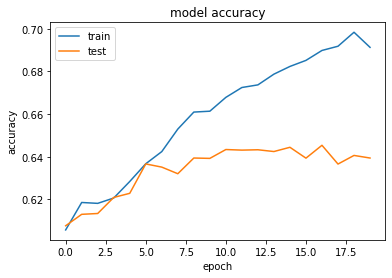

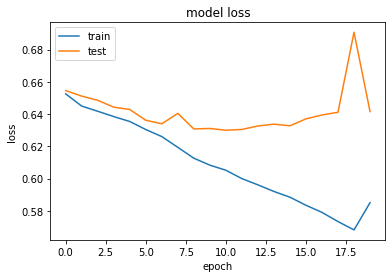

In [15]:
# Thanks Jason Brownlee
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<br><br>

# **Building the model: 100-1**

In [27]:
model = None

model = Sequential()

model.add(Masking(mask_value=mask_value,
                  input_shape=(series_len, 1)))

model.add(LSTM(100))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_3 (Masking)          (None, 100, 1)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100, 100)          40800     
_________________________________________________________________
dense_3 (Dense)              (None, 100, 1)            101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=64)

Epoch 1/30
420/420 [==============================] - 49s 118ms/step - loss: 0.6222 - accuracy: 0.6509 - val_loss: 0.6402 - val_accuracy: 0.6298
Epoch 2/30
420/420 [==============================] - 48s 115ms/step - loss: 0.6223 - accuracy: 0.6503 - val_loss: 0.6363 - val_accuracy: 0.6373
Epoch 3/30
420/420 [==============================] - 47s 112ms/step - loss: 0.6207 - accuracy: 0.6529 - val_loss: 0.6353 - val_accuracy: 0.6410
Epoch 4/30
420/420 [==============================] - 48s 113ms/step - loss: 0.6193 - accuracy: 0.6540 - val_loss: 0.6374 - val_accuracy: 0.6380
Epoch 5/30
420/420 [==============================] - 45s 107ms/step - loss: 0.6170 - accuracy: 0.6558 - val_loss: 0.6365 - val_accuracy: 0.6389
Epoch 6/30
420/420 [==============================] - 45s 106ms/step - loss: 0.6162 - accuracy: 0.6552 - val_loss: 0.6378 - val_accuracy: 0.6376
Epoch 7/30
420/420 [==============================] - 45s 106ms/step - loss: 0.6142 - accuracy: 0.6592 - val_loss: 0.6370 - val_ac

In [25]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 63.35%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


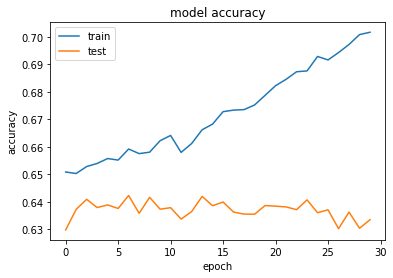

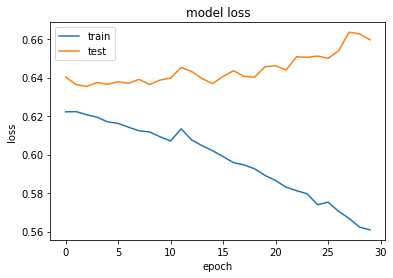

In [26]:
# Thanks Jason Brownlee
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<br><br>

# **Building the model: 100-50-25 w/ dropout**

In [31]:
model = None

model = Sequential()

model.add(Masking(mask_value=mask_value,
                  input_shape=(series_len, 1)))

model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))


model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))


model.add(LSTM(25))
model.add(Dropout(0.2))


model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_6 (Masking)          (None, 100, 1)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 100, 50)           30200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 25)                7600      
_________________________________________________________________
dropout_11 (Dropout)         (None, 25)               

In [32]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=64)

Epoch 1/20
420/420 [==============================] - 129s 307ms/step - loss: 0.6874 - accuracy: 0.5389 - val_loss: 0.6855 - val_accuracy: 0.5412
Epoch 2/20
420/420 [==============================] - 124s 295ms/step - loss: 0.6835 - accuracy: 0.5563 - val_loss: 0.6810 - val_accuracy: 0.5709
Epoch 3/20
420/420 [==============================] - 123s 293ms/step - loss: 0.6746 - accuracy: 0.5739 - val_loss: 0.6670 - val_accuracy: 0.5866
Epoch 4/20
420/420 [==============================] - 126s 301ms/step - loss: 0.6639 - accuracy: 0.5953 - val_loss: 0.6614 - val_accuracy: 0.6039
Epoch 5/20
420/420 [==============================] - 125s 297ms/step - loss: 0.6580 - accuracy: 0.6086 - val_loss: 0.6586 - val_accuracy: 0.6071
Epoch 6/20
420/420 [==============================] - 123s 292ms/step - loss: 0.6545 - accuracy: 0.6121 - val_loss: 0.6587 - val_accuracy: 0.6071
Epoch 7/20
420/420 [==============================] - 121s 288ms/step - loss: 0.6526 - accuracy: 0.6120 - val_loss: 0.6547 -

In [33]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 63.79%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


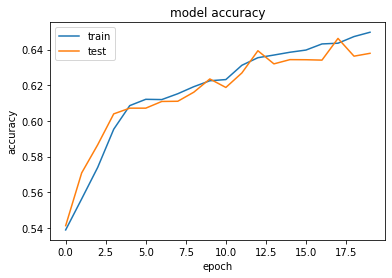

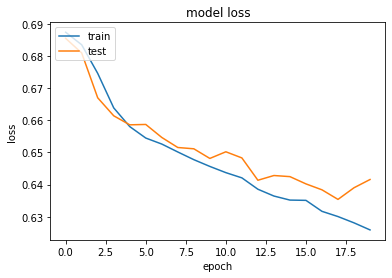

In [34]:
# Thanks Jason Brownlee
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<br><br>

# **Building the model: 100-50-25-10 w/ dropout**

In [51]:
model = None

model = Sequential()

model.add(Masking(mask_value=mask_value,
                  input_shape=(series_len, 1)))

model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))


model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))


model.add(LSTM(25, return_sequences=True))
model.add(Dropout(0.2))


model.add(LSTM(10))
model.add(Dropout(0.2))

model.add(Dense(1))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_16 (Masking)         (None, 100, 1)            0         
_________________________________________________________________
lstm_50 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
dropout_42 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
lstm_51 (LSTM)               (None, 100, 50)           30200     
_________________________________________________________________
dropout_43 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
lstm_52 (LSTM)               (None, 100, 25)           7600      
_________________________________________________________________
dropout_44 (Dropout)         (None, 100, 25)         

In [53]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40, batch_size=64)

Epoch 1/40
420/420 [==============================] - 150s 357ms/step - loss: 0.6852 - accuracy: 0.5467 - val_loss: 0.6842 - val_accuracy: 0.5423
Epoch 2/40
420/420 [==============================] - 146s 349ms/step - loss: 0.6830 - accuracy: 0.5625 - val_loss: 0.6815 - val_accuracy: 0.5686
Epoch 3/40
420/420 [==============================] - 143s 340ms/step - loss: 0.6804 - accuracy: 0.5671 - val_loss: 0.6780 - val_accuracy: 0.5742
Epoch 4/40
420/420 [==============================] - 142s 338ms/step - loss: 0.6741 - accuracy: 0.5773 - val_loss: 0.6736 - val_accuracy: 0.5746
Epoch 5/40
420/420 [==============================] - 141s 336ms/step - loss: 0.6671 - accuracy: 0.5916 - val_loss: 0.6686 - val_accuracy: 0.5955
Epoch 6/40
420/420 [==============================] - 142s 338ms/step - loss: 0.6602 - accuracy: 0.6056 - val_loss: 0.6603 - val_accuracy: 0.6072
Epoch 7/40
420/420 [==============================] - 144s 343ms/step - loss: 0.6570 - accuracy: 0.6069 - val_loss: 0.6599 -

In [54]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 64.10%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


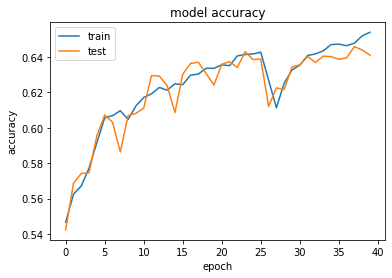

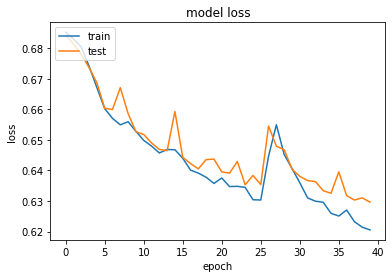

In [55]:
# Thanks Jason Brownlee
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [57]:
if (0):
    model.save(os.path.join('keras', 'LSTM_tree'))
    with open(os.path.join("keras", "LSTM_tree_history.pickle"), 'wb') as f: pickle.dump(history, f)    #dump this model's history
if (0):
    model = keras.models.load_model(os.path.join('keras', 'LSTM_tree'))

# for layer in model.layers:
#     print(layer.output_shape)

text = "In this example, we developed a working Neural Network for the binary classification problem. The same problem can also be solved using other algorithms such as Logistic Regression, Naive Bayes, K-Nearest Neighbours. The choice of the algorithm to choose needs to be driven by the problem at hand and factors like, how much data size is available, computation power, etc. Deep Networks or Neural Networks are generally recommended if the available data size is large."
sentiments = text_to_sentiments(text)

print("sentiments shape: ", sentiments.shape)

print("real - predicted")
for num in range(1010,1020):
    scores = bool((model.evaluate(np.array([X_test[num]]), np.array([y_test[num]]), verbose=0, return_dict=True))['accuracy'])
    prediction = model(np.array([X_test[num]]))
    print("{} = {}:  {} - {} ({:.4f}...)".format(num, scores, y_test[num], round(float(prediction.numpy())), float(prediction.numpy())))

In [68]:
from keras.utils import plot_model
plot_model(model, to_file='/tmp/model.png', show_shapes=True,)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
